In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torch import optim, cuda
import time

In [ ]:

#@torch.no_grad()
def diplayImage(out):
  img = out.detach().cpu().numpy()
  ch = img.shape[1]
  for i in range(ch):
    plt.matshow(img[0, i, :, :], cmap='viridis')
    plt.title("channel number"+str(i))
  

In [ ]:
def build_dataset(batch_size):

   transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

   trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transformations)
   testset = dsets.CIFAR10('./data', train=False, download=True, transform=transformations)

   train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
   test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

   return train_loader,test_loader

In [ ]:
class CNNCifarModel(nn.Module):

    def __init__(self):
        super(CNNCifarModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
               
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
         
        # Fully connected 1 
        self.fc1 = nn.Linear(64 * 5 * 5, 128)

         # Fully connected 2 
        self.fc2 = nn.Linear(128, 10)

        # Dropout
        self.Dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # list for activations
        listActivations = []
        # list for kernels
        listKernels = []

      # x =  torch.Size([100, 3, 32, 32])
      # we define a list 
        # Convolution 1
        cnn1 = self.cnn1(x) #torch.Size([100, 32, 28, 28])
        act1 = self.relu1(cnn1) #torch.Size([100, 32, 28, 28])
        
        # Max pool 1
        hybridp1 = self.HybridPool(act1) #torch.Size([100, 32, 14, 14])

        hybridp1 = self.Dropout(hybridp1) #torch.Size([100. 32, 14, 14])
         
        # Convolution 2 
        cnn2 = self.cnn2(hybridp1) #torch.Size([100, 64, 10, 10])
        act2 = self.relu2(cnn2) #torch.Size([100, 64, 10, 10])
       
        # Max pool 2 
        hybridp2 = self.HybridPool(act2) #torch.Size([100, 64, 5, 5])

        hybridp2 = self.Dropout(hybridp2) #torch.Size([100. 64, 5, 5])
  
        out = hybridp2.view(hybridp2.size(0), -1)   #torch.Size([100, 1600])

        
        # Store the listActivatios and listKernel
        listKernels = [cnn1,cnn2]
        listActivations =[act1,act2,hybridp1,hybridp2]

        # Linear function (readout)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

         
        return out,listKernels,listActivations


    def HybridPool(self,  input, kernel_size = 2, alpha = 0.5):

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2)

        max = self.maxpool(input) 
        avg = self.avgpool(input)

        result = torch.add(alpha*max,(1-alpha)*avg)
        return result    

In [ ]:
def train(model,dataloader,optimizer,epoch):
    model.train()
    averLoss = []
    criterion = nn.CrossEntropyLoss().to(device) 
    for batch_idx, (images,target) in enumerate(dataloader):
        images, target = images.to(device), target.to(device)
        optimizer.zero_grad() # to clean the gradient
        output,listKernels,listActivations = model(images)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
            averLoss.append(loss.item())
    return sum(averLoss)/len(averLoss),listKernels,listActivations

def test(model,testloader):
    model.eval(
    total = 0
    correct = 0
    criterion = nn.CrossEntropyLoss().to(device) 
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output,listKernels,listActivations = model(images)
        _, predicted = torch.max(output.data, 1) 
        # Total number of labels
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum().float()
    accuracy = 100. * correct / total
    print('Accuracy: {}'.format(accuracy))
    return accuracy,listKernels,listActivations         

In [ ]:
torch.manual_seed(43)
device = 'cuda' if cuda.is_available() else 'cpu'
model = CNNCifarModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
historyLoss = []
historyEpoch = []
since = time.time()
num_epocs = 30
batch_size = 100
trainloader,testloader = build_dataset(batch_size)

for epoch in range(1, num_epocs):
  epoch_start = time.time()
  averLoss,listKernels,listActivations= train(model,trainloader,optimizer,epoch)
  historyEpoch.append(epoch)
  historyLoss.append(averLoss)
  m, s = divmod(time.time() - epoch_start, 60)
  print(f'Training time: {m:.0f}m {s:.0f}s')
  test(model,testloader)
  m, s = divmod(time.time() - epoch_start, 60)
  print(f'Testing time: {m:.0f}m {s:.0f}s')
  m, s = divmod(time.time() - since, 60)
  print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 1 | Batch Status: 0/50000 (0%) | Loss: 2.295519
Train Epoch: 1 | Batch Status: 10000/50000 (20%) | Loss: 1.729545


KeyboardInterrupt: ignored

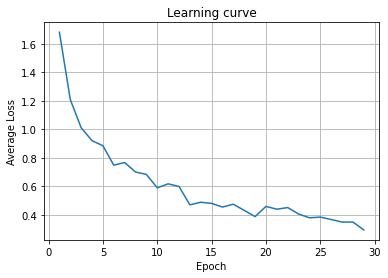

In [ ]:
plt.plot(historyEpoch,historyLoss)
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()
  

List Kernel 1 of the last epoch:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


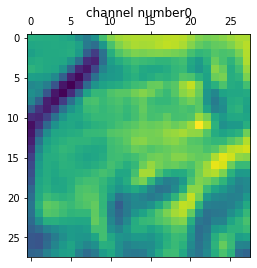

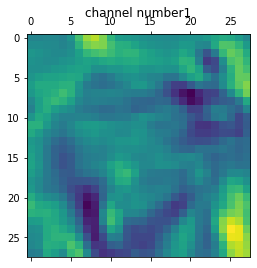

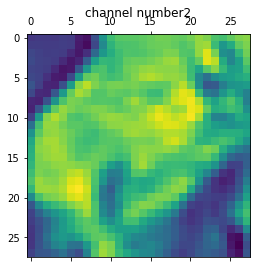

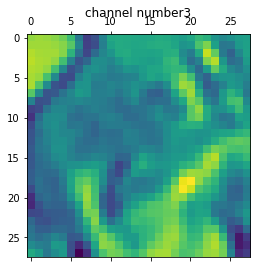

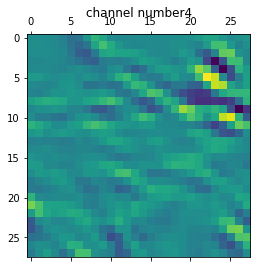

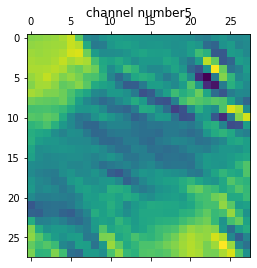

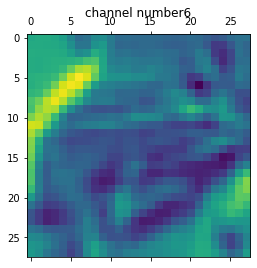

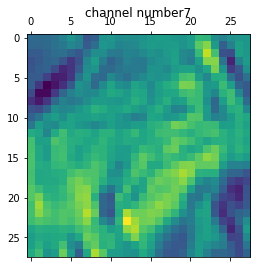

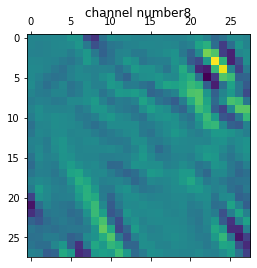

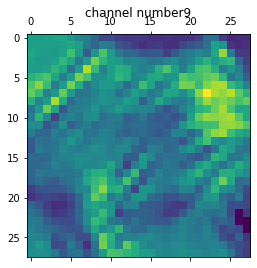

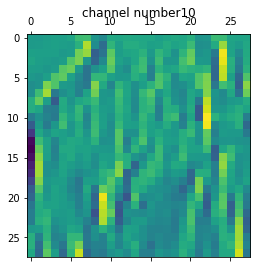

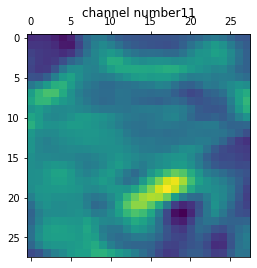

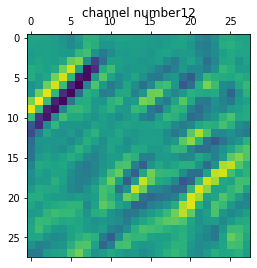

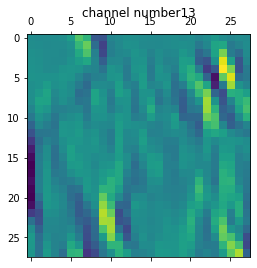

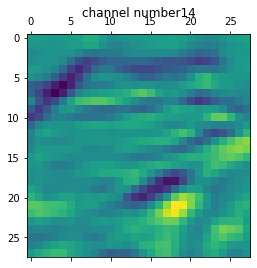

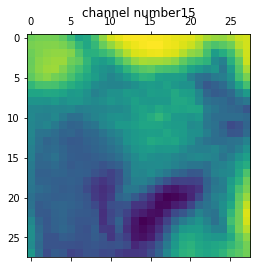

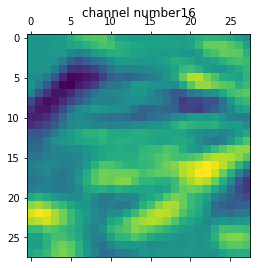

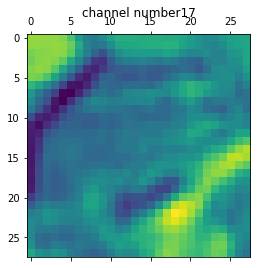

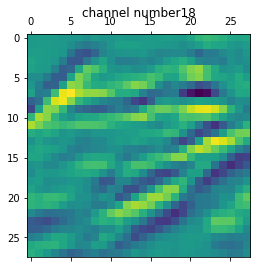

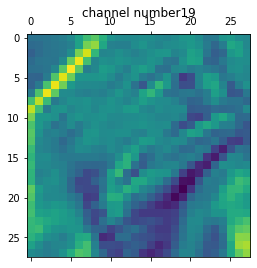

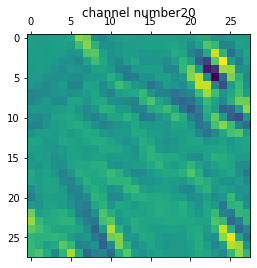

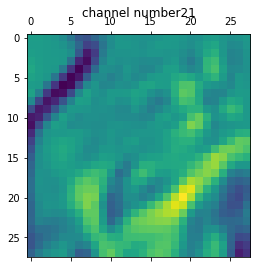

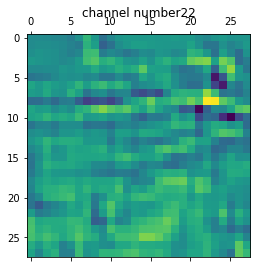

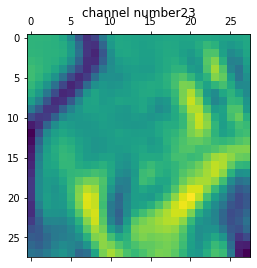

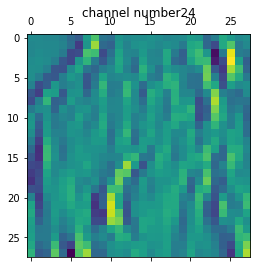

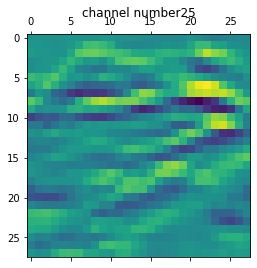

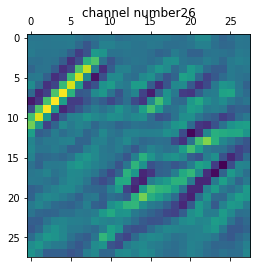

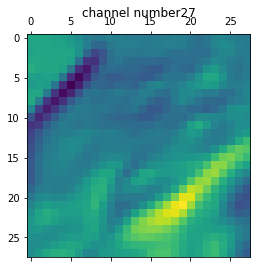

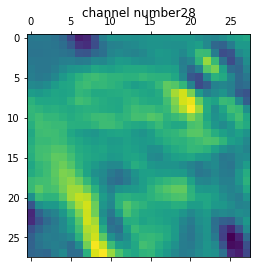

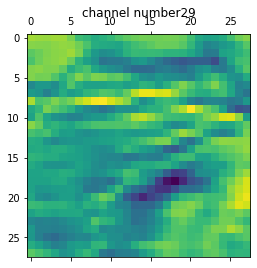

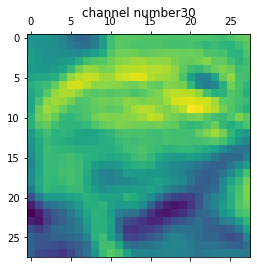

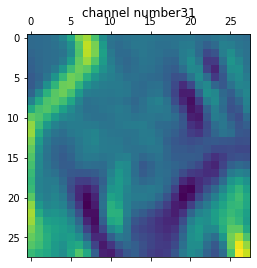

In [ ]:
  print("List Kernel 1 of the last epoch:\n")
  #listKernels[1]
  diplayImage(listKernels[0])
  #diplayImage(listKernels[1])
 

List Kernel 2 of the last epoch:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


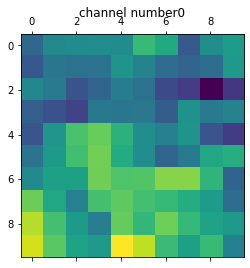

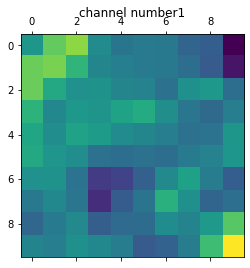

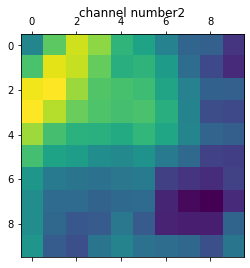

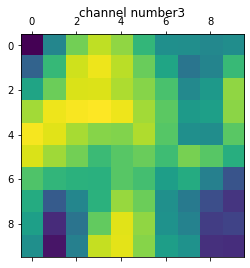

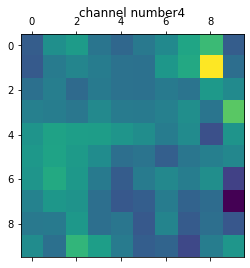

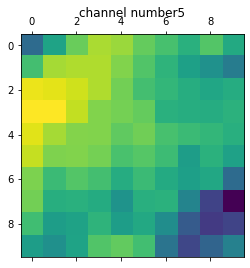

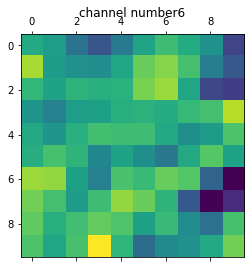

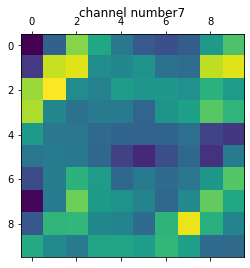

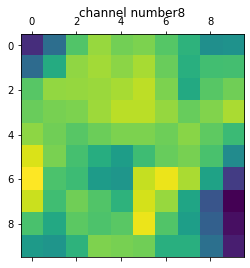

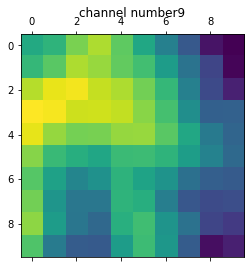

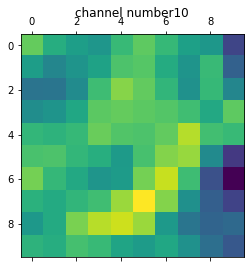

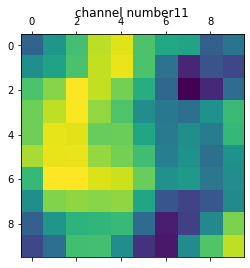

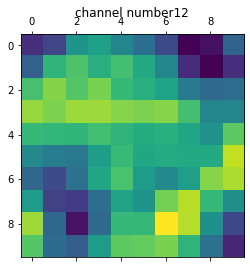

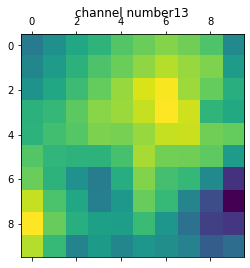

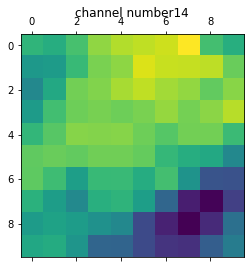

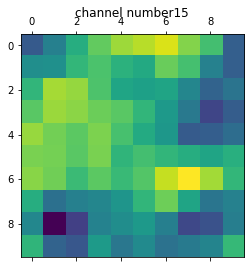

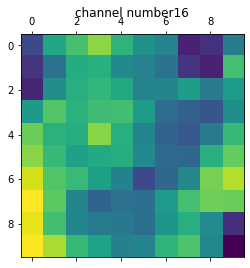

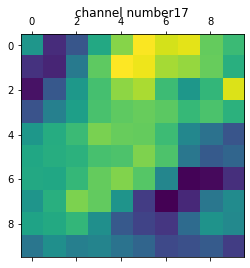

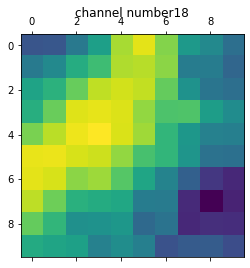

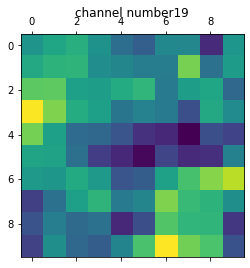

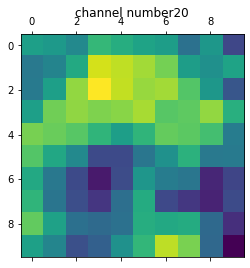

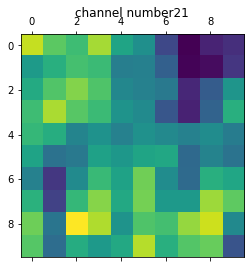

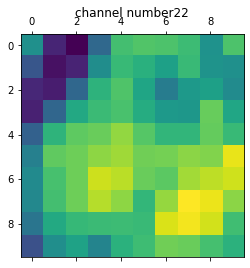

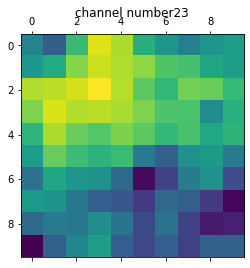

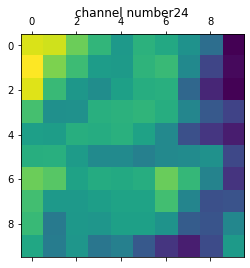

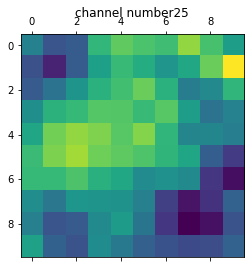

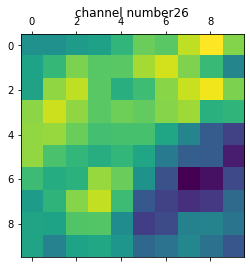

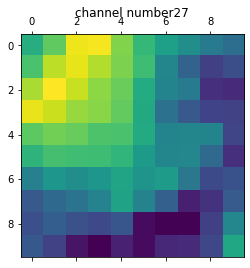

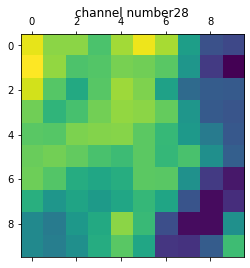

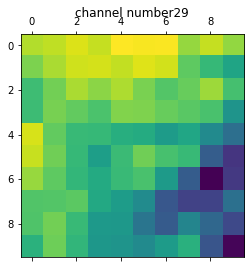

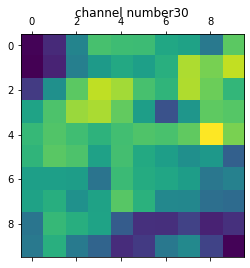

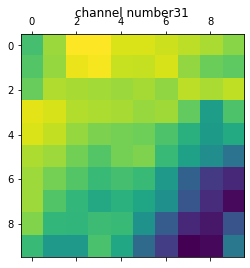

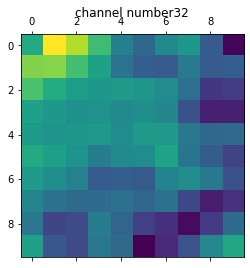

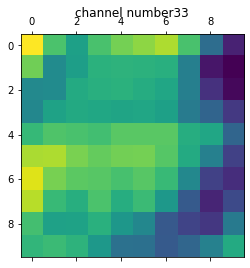

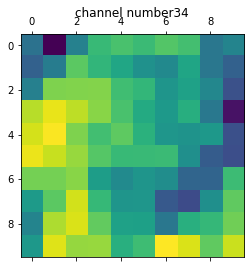

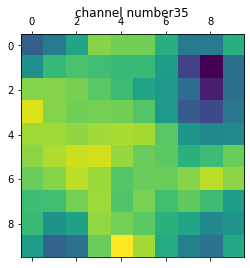

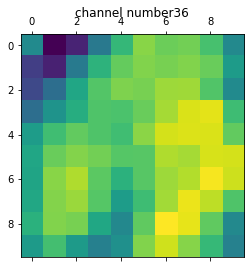

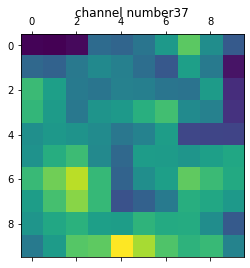

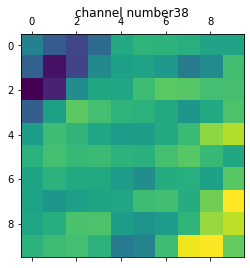

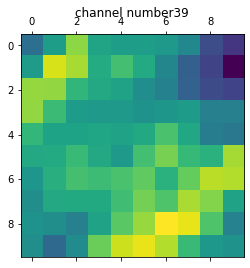

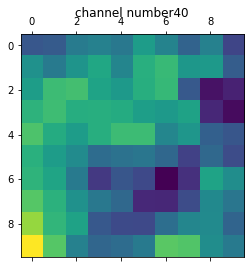

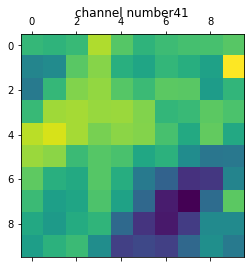

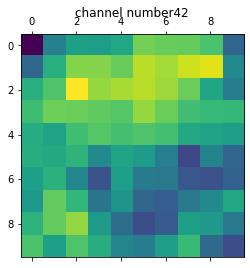

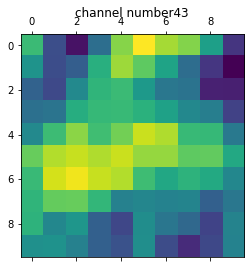

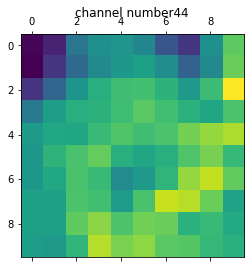

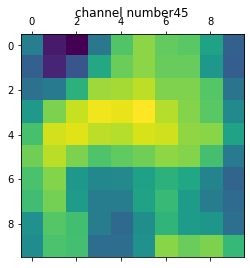

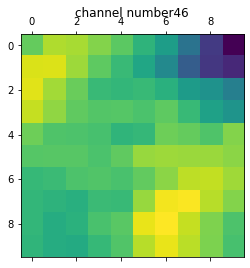

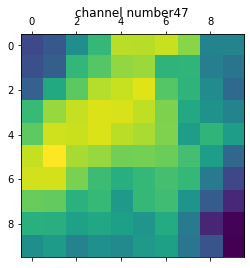

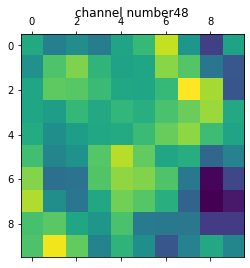

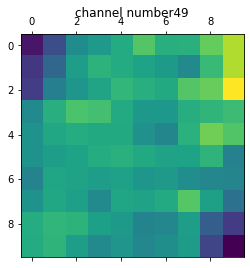

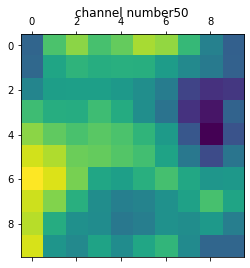

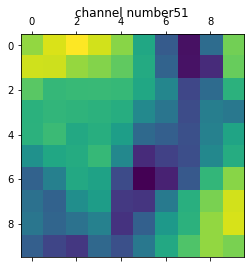

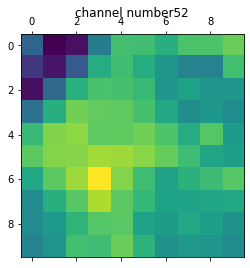

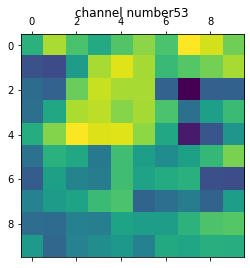

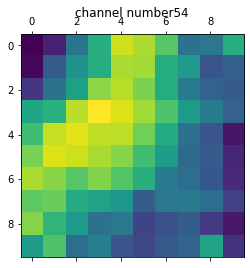

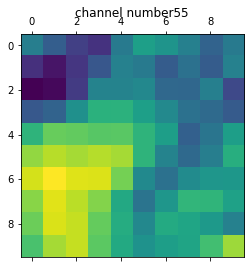

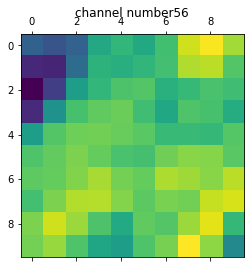

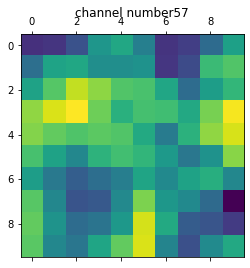

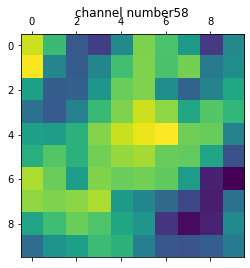

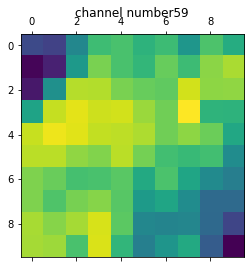

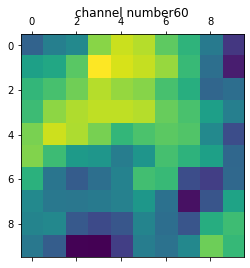

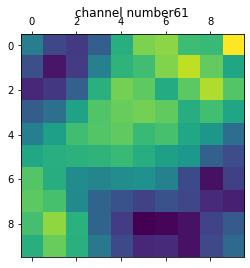

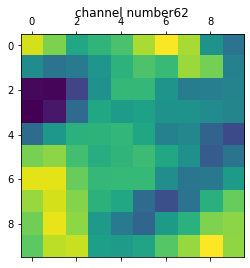

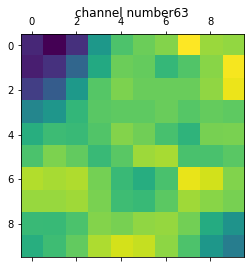

In [ ]:
print("List Kernel 2 of the last epoch:\n")
diplayImage(listKernels[1])

List Activations 1 of the last epoch (relus and maxpool):



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


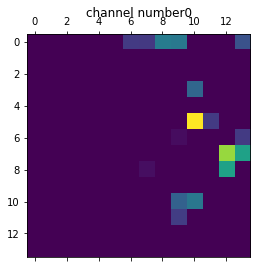

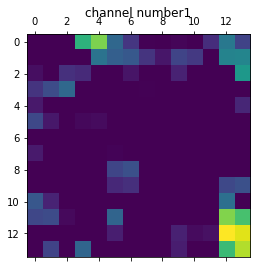

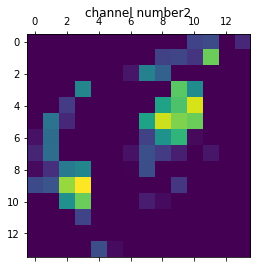

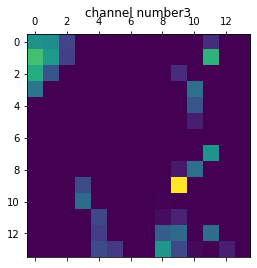

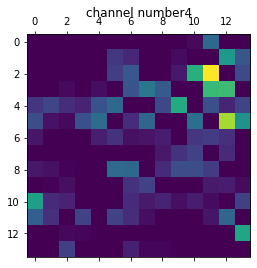

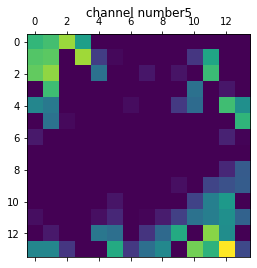

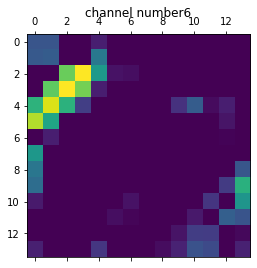

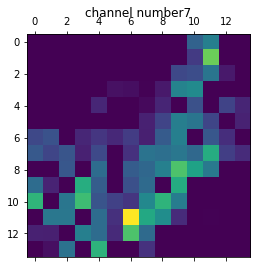

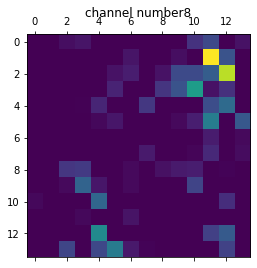

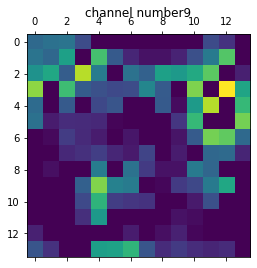

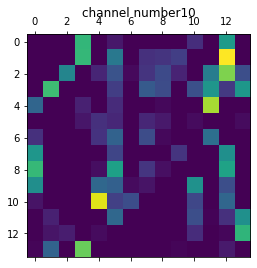

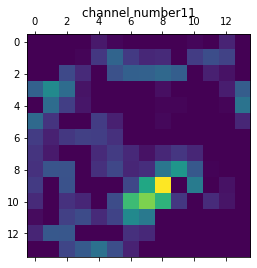

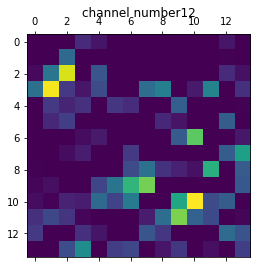

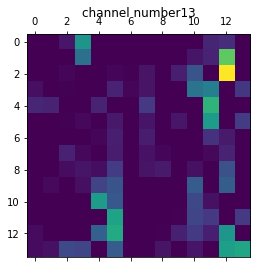

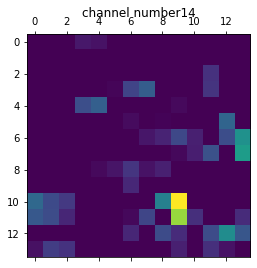

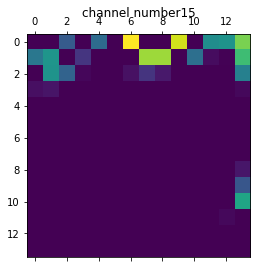

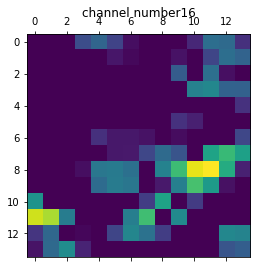

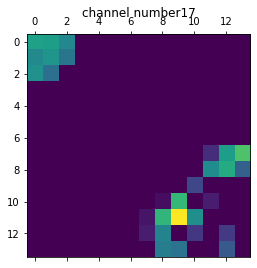

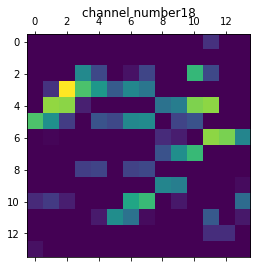

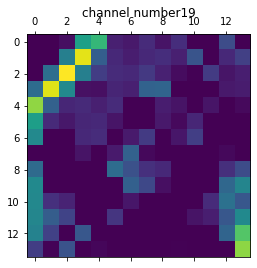

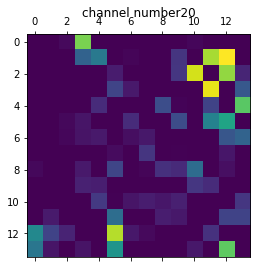

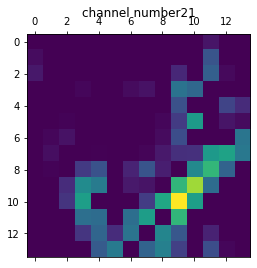

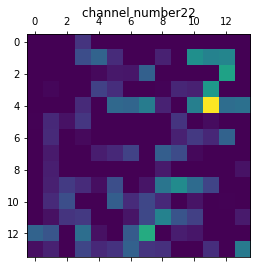

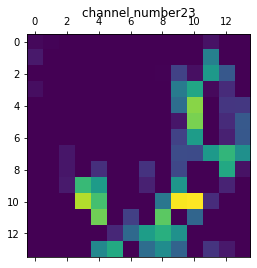

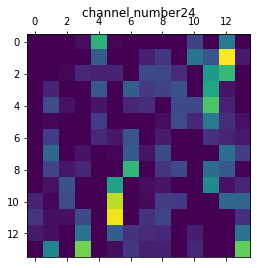

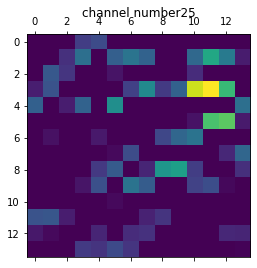

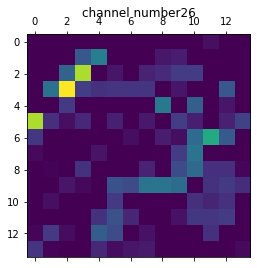

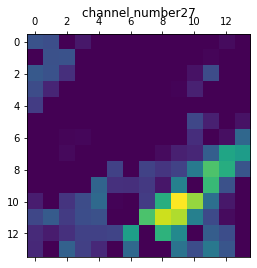

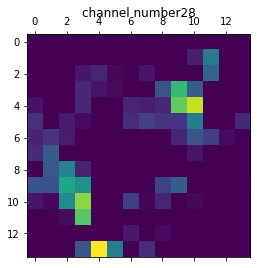

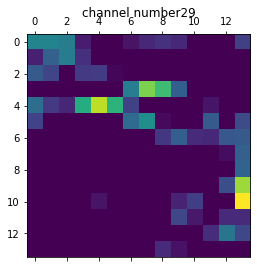

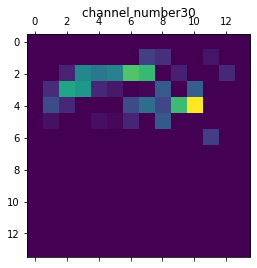

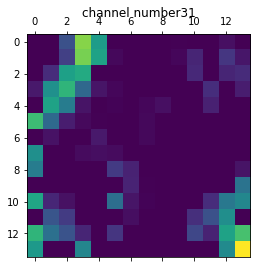

In [ ]:
# Please vary the numbers from 0 to 4
print("List Activations 1 of the last epoch (relus and maxpool):\n")
diplayImage(listActivations[2])


Take a Convolutional layer with the appropriate kernel size and load the trained weight/bias into an FC layer (You should think about in what situation you can have convolutional layer like FC layer)

Reference: https://cs231n.github.io/convolutional-networks/ The only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between FC and CONV layers.

We can thus define the CNN filter to be the same as the input size to make the connections similar to an FC layer. The number of output channels in the Conv layer then act as the number of output neurons in the equivalent FC layer.

For this task we create a simple model with one convolution layer and one FC layer 


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
         
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=32, stride=1, padding=0)
        self.relu = nn.ReLU()
         
         
        self.fc1 = nn.Linear(32, 10)


 
    
    def forward(self, x):
        # x =  torch.Size([100, 3, 32, 32])
        # Convolution 1

        
        out = self.cnn1(x) #torch.Size([100, 32, 1, 1])
        out = self.relu(out) #torch.Size([100, 32, 1, 1])
 
        out = out.view(out.size(0), -1) #torch.Size([100, 32])
        
        out = self.fc1(out)
             
        return out

model = CNNModel()
 
#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()


criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

CNNModel(
  (cnn1): Conv2d(3, 32, kernel_size=(32, 32), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)


We then train this simple model with 1 conv layer over the CIFAR Dataset for 5 epochs and validate the test error too.

In [ ]:
iter = 0
num_epochs = 5
batch_size = 100
train_loader,test_loader = build_dataset(batch_size)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        #print(images.shape)
        #print(labels.shape)
 
         
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)


        '''
        count = 0

        for param in model.parameters():
          count+=1
          print(count,' count',param.shape)

        #import pdb; pdb.set_trace()
        # Calculate Loss: softmax --> cross entropy loss
        '''

        loss = criterion(outputs, labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = images.cuda()
                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                correct += (predicted.cpu() == labels.cpu()).sum().float()
 
             
            accuracy = 100. * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Iteration: 500. Loss: 1.70546293258667. Accuracy: 44.04999923706055
Iteration: 1000. Loss: 1.771347165107727. Accuracy: 45.630001068115234
Iteration: 1500. Loss: 1.5531944036483765. Accuracy: 46.81999969482422
Iteration: 2000. Loss: 1.383359670639038. Accuracy: 47.59000015258789
Iteration: 2500. Loss: 1.3933699131011963. Accuracy: 48.369998931884766


______

WE PRINT BELOW THE MODEL'S ACCURACY ON THE TEST SET BATCHES 

In [ ]:
iter = 0
#for epoch in range(num_epochs):      
            # Iterate through test dataset
for images, labels in test_loader:

  iter += 1

  if iter % 10 == 0:
    # Calculate Accuracy         
    correct = 0
    total = 0
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if torch.cuda.is_available():
        images = images.cuda()
      
    # Forward pass only to get logits/output
    outputs = model(images)
      
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
      
    # Total number of labels
    total += labels.size(0)
      
    # Total correct predictions
    correct += (predicted.cpu() == labels.cpu()).sum().float()

  
    accuracy = 100. * correct / total
  
    # Print Loss
    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 10. Loss: 1.3933699131011963. Accuracy: 59.0
Iteration: 20. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 30. Loss: 1.3933699131011963. Accuracy: 53.0
Iteration: 40. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 50. Loss: 1.3933699131011963. Accuracy: 44.0
Iteration: 60. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 70. Loss: 1.3933699131011963. Accuracy: 45.0
Iteration: 80. Loss: 1.3933699131011963. Accuracy: 41.0
Iteration: 90. Loss: 1.3933699131011963. Accuracy: 49.0
Iteration: 100. Loss: 1.3933699131011963. Accuracy: 44.0


____________

We now define a similar network where we replace the Conv layer with an FC layer. This network now has only 2 FC layers instead of 1 Conv and 1 FC

In [ ]:
class FCEquivalent(nn.Module):
    def __init__(self):
        super(FCEquivalent, self).__init__()
         
   
        self.fc1 = nn.Linear(3072, 32)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(32,10)


 
    
    def forward(self, x):
        # x =  torch.Size([100, 3, 32, 32])
        # Convolution 1


        x =  x.view(x.size(0),-1)
        
        out = self.fc1(x) 
        out = self.relu(out) 
        
        out = self.fc2(out)
             
        return out

model_fc = FCEquivalent()
 
#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()

print(model_fc)

FCEquivalent(
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


Load the weights and biases pre-trained from the CONV layer (and the additional FC layer) to the replacement networks

In [ ]:
model_fc.fc1.weight = torch.nn.parameter.Parameter(model.cnn1.weight.reshape([32,3072]))
model_fc.fc1.bias = torch.nn.parameter.Parameter(model.cnn1.bias.reshape([32]))
model_fc.fc2.weight = model.fc1.weight
model_fc.fc2.bias = model.fc1.bias

We now directly test the performance of this model with the loaded weights on the validation dataset


In [ ]:
iter = 0
#for epoch in range(num_epochs):      
            # Iterate through test dataset
for images, labels in test_loader:

  iter += 1

  if iter % 10 == 0:
    # Calculate Accuracy         
    correct = 0
    total = 0
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if torch.cuda.is_available():
        images = images.cuda()
      
    # Forward pass only to get logits/output
    outputs = model_fc(images)
      
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
      
    # Total number of labels
    total += labels.size(0)
      
    # Total correct predictions
    correct += (predicted.cpu() == labels.cpu()).sum().float()

  
    accuracy = 100. * correct / total
  
    # Print Loss
    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 10. Loss: 1.3933699131011963. Accuracy: 59.0
Iteration: 20. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 30. Loss: 1.3933699131011963. Accuracy: 53.0
Iteration: 40. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 50. Loss: 1.3933699131011963. Accuracy: 44.0
Iteration: 60. Loss: 1.3933699131011963. Accuracy: 51.0
Iteration: 70. Loss: 1.3933699131011963. Accuracy: 45.0
Iteration: 80. Loss: 1.3933699131011963. Accuracy: 41.0
Iteration: 90. Loss: 1.3933699131011963. Accuracy: 49.0
Iteration: 100. Loss: 1.3933699131011963. Accuracy: 44.0


We see that the Validation performance for the CNN and the FC equivalent networks after replacement are similar